In [1]:
import os,sys,inspect
import numpy as np
import matplotlib.pyplot as plt

import torch

torch.set_default_dtype(torch.float32)

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from generative_model import glow_model
from generative_model import realnvpfc_model
from DPI_MRI import Img_logscale, readMRIdata

# Load the learned DPI normalizing flow for MRI

In [2]:
# define the normalizing flow network
device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")
npix = 64
n_flow = 16
affine = True
img_generator = realnvpfc_model.RealNVP(npix*npix, n_flow, affine=affine).to(device)
logscale_factor = Img_logscale(scale=0.1/(0.8*npix*npix)).to(device)

generator_file = '../checkpoint/mri/generativemodel_realnvp_ratio4.0_res64flow16logdet1.0_tv'
logscale_file = '../checkpoint/mri/generativescale_realnvp_ratio4.0_res64flow16logdet1.0_tv'
img_generator.load_state_dict(torch.load(generator_file, map_location=device))
logscale_factor.load_state_dict(torch.load(logscale_file, map_location=device))
# img_generator.eval()
# logscale_factor.eval()

<All keys matched successfully>

# Generate and plot image samples

In [3]:
n_sample = 128#1024#
z_sample = torch.randn(n_sample, npix*npix).to(device=device)

# generate image samples
img_samp, logdet = img_generator.reverse(z_sample)
img_samp = img_samp.reshape((-1, npix, npix))

# apply scale factor and sigmoid/softplus layer for positivity constraint
logscale_factor_value = logscale_factor.forward()
scale_factor = torch.exp(logscale_factor_value)
img = torch.nn.Softplus()(img_samp) * scale_factor
image = img.detach().cpu().numpy()

(<Figure size 1080x1080 with 1 Axes>,
 Text(0.5, 1.0, 'DPI generated MRI image samples'))

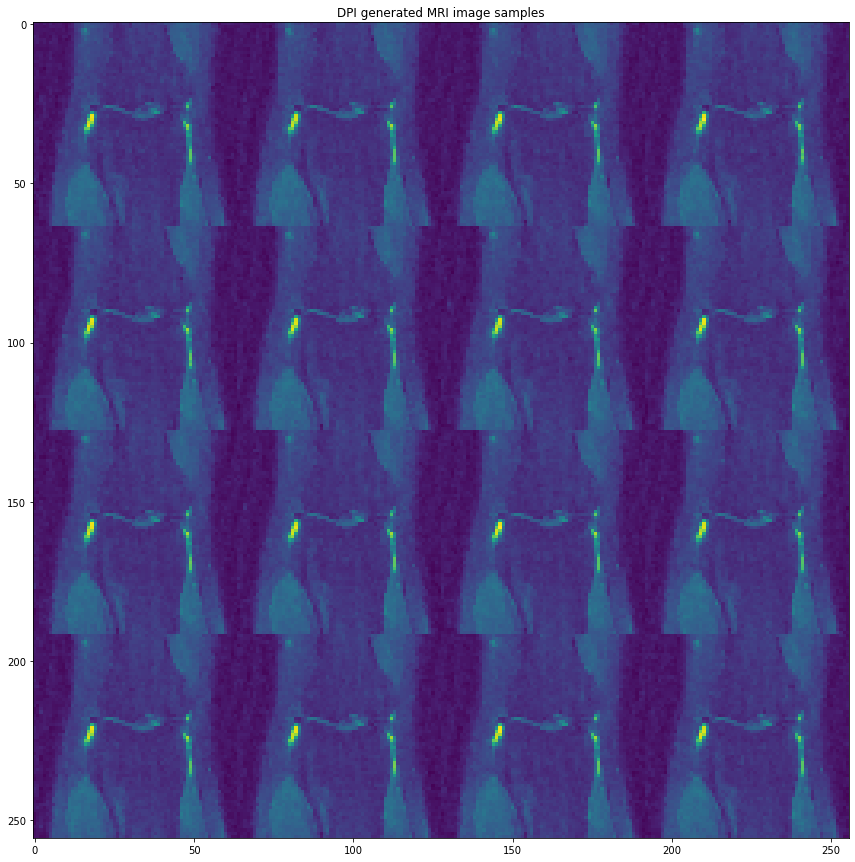

In [4]:
image_stitch = np.zeros((npix*4, npix*4))
for k in range(16):
    i = k//4
    j = k%4
    image_stitch[npix*i:npix*(i+1), npix*j:npix*(j+1)] = image[k]
plt.figure(figsize = (15,15)), plt.imshow(image_stitch), plt.title('DPI generated MRI image samples')

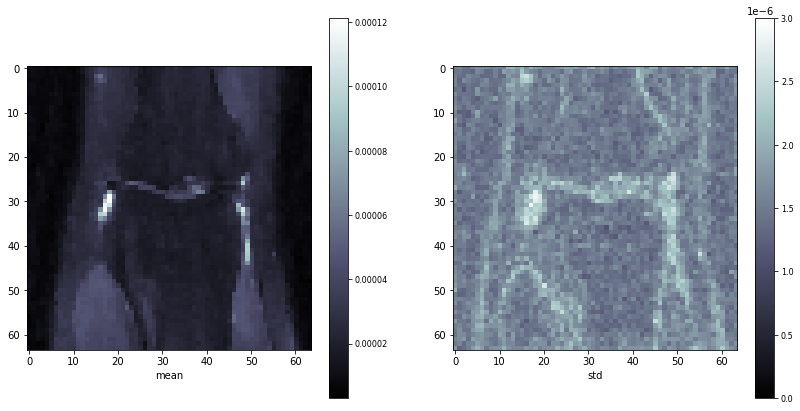

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# plot mode#1
im = axs[0].imshow(np.mean(image, 0), cmap='bone')
axs[0].set(xlabel='mean')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.tick_params(labelsize=8)

im = axs[1].imshow(np.std(image, 0), cmap='bone', vmin=0, vmax=3e-6)
axs[1].set(xlabel='std')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.tick_params(labelsize=8)